# Preliminary operations

In [1]:
#@title Drive mount
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#@title Main libraries
import pandas as pd
import numpy as np

import os
import random

from sklearn.utils import  compute_class_weight

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

In [3]:
#@title Reproducibility
# Setting a seed for reproducibility
seed = 90 
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("The seed is: " + str(seed))

The seed is: 90


#Functions

In [ ]:
def unfreeze_layers(tl_model, untill, supernet_name,lr):

  tl_model.get_layer(supernet_name).trainable = True
  for i, layer in enumerate(tl_model.get_layer(supernet_name).layers[:untill]):
    layer.trainable=False
  for i, layer in enumerate(tl_model.get_layer(supernet_name).layers):
    print(i, layer.name, layer.trainable)

  tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(lr), metrics=['accuracy', 'Precision', 'Recall'])

  return tl_model

In [ ]:
def evaluate_model_m(model, test_set, target):

  """ Function used to evaluate model's performances on the local test set, display of confusion matrix """
  """ Model from trained model variable """

  labels = list(test_set.class_indices.keys())
  
  predictions = model.predict(test_set)
  metrics= {
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true', ),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro')  }
  
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(15,15))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels), yticklabels=list(labels))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

# Access data

### Data hyperparameters

In [4]:
data_hyperparameters = {
    'batch_size': 128,
    'resized_shape_height': 224, # as in chex net
    'resized_shape_width': 224,
    'color_mode': 'rgb' #'grayscale'
}

### Defining augmentation

In [5]:
# This function is used to create a dictionary with the hyperparameters of the augmentation 
def get_augmentation_hyperparameters(selected_dictionary):
  
  if selected_dictionary==0:
    augmentation_hyperparameters={}
    augmentation_hyperparameters['name']= 'Basic_Augmentation'
    augmentation_hyperparameters['rotation_range']= 45
    augmentation_hyperparameters['width_shift_range']= 0
    augmentation_hyperparameters['height_shift_range']= 0
    augmentation_hyperparameters['brightness_range']= [0.8, 1.2]
    augmentation_hyperparameters['horizontal_flip']= True
    augmentation_hyperparameters['vertical_flip']= False
    augmentation_hyperparameters['zoom_range']= [0.7, 1.2]
    augmentation_hyperparameters['rescale_range']= 1/255.
    augmentation_hyperparameters['fill_mode']= 'reflect'
    augmentation_hyperparameters['cval']= 0
    
  elif selected_dictionary==1:
    augmentation_hyperparameters={}
    augmentation_hyperparameters['name']= 'Aggressive_Augmentation'
    augmentation_hyperparameters['rotation_range']= 90
    augmentation_hyperparameters['width_shift_range']= 0.2
    augmentation_hyperparameters['height_shift_range']= 0.2
    augmentation_hyperparameters['brightness_range']= [0.5, 1.5]
    augmentation_hyperparameters['horizontal_flip']= True
    augmentation_hyperparameters['vertical_flip']= False
    augmentation_hyperparameters['zoom_range']= [0.5, 1.5]
    augmentation_hyperparameters['rescale_range']= 1/255.
    augmentation_hyperparameters['fill_mode']= 'reflect'
    augmentation_hyperparameters['cval']= 0

  elif selected_dictionary==2:
    augmentation_hyperparameters={}
    augmentation_hyperparameters['name']= 'Kind_Augmentation'
    augmentation_hyperparameters['rotation_range']= 0
    augmentation_hyperparameters['width_shift_range']= 0.1
    augmentation_hyperparameters['height_shift_range']= 0.1
    augmentation_hyperparameters['brightness_range']=  [0.9, 1.1]
    augmentation_hyperparameters['horizontal_flip']= True
    augmentation_hyperparameters['vertical_flip']= False
    augmentation_hyperparameters['zoom_range']= [0.9, 1.1]
    #augmentation_hyperparameters['rescale_range']= 1.
    augmentation_hyperparameters['fill_mode']= 'reflect'
    augmentation_hyperparameters['cval']= 0
  
  return augmentation_hyperparameters

In [6]:
dictionary = get_augmentation_hyperparameters(2)


aug_train_gen = ImageDataGenerator(
    rotation_range = dictionary['rotation_range'],
    height_shift_range = dictionary['height_shift_range'],
    width_shift_range = dictionary['width_shift_range'], 
    zoom_range = dictionary['zoom_range'],
    horizontal_flip = dictionary['horizontal_flip'],
    vertical_flip = dictionary['vertical_flip'], 
    fill_mode = dictionary['fill_mode'],
    cval = dictionary['cval'],
    #rescale = dictionary['rescale_range'],
    brightness_range = dictionary['brightness_range'],
    #preprocessing_function= preprocess_input)
)

In [7]:
os.getcwd()

'/content'

### Data generators

In [8]:
dataset_dir = "/content/gdrive/MyDrive/Assignment/Clean_And_Preprocessed_Dataset/CLEAN_and_FCDNP" #TODO
training_dir = os.path.join(dataset_dir, 'TRAIN')
validation_dir = os.path.join(dataset_dir, 'VAL')
test_dir = os.path.join(dataset_dir, 'TEST')

In [9]:
aug_training_set = aug_train_gen.flow_from_directory(directory = training_dir,
                                                  target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                  color_mode = data_hyperparameters['color_mode'],
                                                  class_mode = 'categorical',
                                                  batch_size = data_hyperparameters['batch_size'],
                                                  shuffle = True,
                                                  seed = seed)

noaug_training_set = ImageDataGenerator().flow_from_directory(directory = training_dir,
                                                                              target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                              color_mode = data_hyperparameters['color_mode'],
                                                                              class_mode = 'categorical',
                                                                              batch_size = data_hyperparameters['batch_size'],
                                                                              shuffle = True,
                                                                              seed = seed)

validation_set = ImageDataGenerator().flow_from_directory(directory = validation_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = True,
                                                                seed = seed)
test_set = ImageDataGenerator().flow_from_directory(directory = test_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)


Found 11124 images belonging to 3 classes.
Found 11124 images belonging to 3 classes.
Found 1253 images belonging to 3 classes.
Found 3093 images belonging to 3 classes.


In [10]:
# @title Target labels
labels = list(aug_training_set.class_indices.keys())
print("Labels: ", labels)

Labels:  ['normal', 'pneumonia', 'tubercolosis']


In [11]:
# @title Defining input and output

n_channels = 1 if data_hyperparameters['color_mode']=='grayscale' else 3
input_shape = (data_hyperparameters['resized_shape_height'],data_hyperparameters['resized_shape_width'],n_channels) 
n_output = len(labels)

print(input_shape)
print(n_output)

(224, 224, 3)
3


# Model definition

In [ ]:
# @title Building the model
base_model = tfk.applications.EfficientNetB0(
    include_top = False,
    weights = "imagenet",
    input_shape = input_shape
)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
inputs = tfk.Input(shape = input_shape)

In [ ]:
dp_rate1 = 0.3
dp_rate2 = 0.3
nc = 512
elastic_lambda= 1e-3

x = base_model(inputs, training=False)
x = tfk.layers.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(dp_rate1, seed=seed)(x)
x = tfkl.Dense( 
      units=nc, 
      kernel_initializer = tfk.initializers.HeUniform(seed),
      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda))(x)
x=tfkl.LeakyReLU()(x)
x = tfkl.Dropout(dp_rate2, seed=seed)(x)

In [ ]:
outputs = tfkl.Dense(
      n_output, 
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

In [ ]:
model = tfk.Model(inputs, outputs, name='model')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                             

In [ ]:
unfreeze_layers(model, untill=207, supernet_name='efficientnetb0', lr = 1e-3)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                             

# Model training

In [ ]:
#@title Callbacks function 
Running_On_COLAB = 1
from datetime import datetime
def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('/content/gdrive/MyDrive/Assignment/MODELS',model_name)

    print("Model will be saved in: " + str(exps_dir))
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
      
    callbacks = []

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
    callbacks.append(ckpt_callback)


    # Early Stopping
    # --------------
    es_callback = tfk.callbacks.EarlyStopping(monitor=monmtr, patience=20, restore_best_weights=True)
    
    callbacks.append(es_callback)

    # Reduce LR by 1/2 when a plateau is reached
    reduce_LR_callback = tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=3, factor=0.5, min_lr=1e-8)
    callbacks.append(reduce_LR_callback)

    return callbacks

In [ ]:
train_gen = aug_training_set
valid_gen = validation_set
test_gen = test_set

train_target = train_gen.classes
val_target = valid_gen.classes
test_target = test_gen.classes

train_target_cat = tfk.utils.to_categorical(train_gen.classes)
val_target_cat = tfk.utils.to_categorical(valid_gen.classes)
test_target_cat = tfk.utils.to_categorical(test_gen.classes)

## Training 1

In [ ]:
epochs = 20
bs = data_hyperparameters['batch_size']
class_weights = dict(zip(np.unique(train_target), compute_class_weight(class_weight = "balanced", classes = np.unique(train_target), y = train_target)))
monmtr = 'val_accuracy'

In [ ]:
aug_callbacks = create_folders_and_callbacks(model_name= 'FCDNP_EffNet_Training1_pt2') # TODO X 

Model will be saved in: /content/gdrive/MyDrive/Assignment/MODELS/FCDNP_EffNet_Training1_pt2


In [ ]:
history = model.fit(
    x = train_gen,
    epochs = epochs,
    batch_size = bs, 
    validation_data = valid_gen,
    callbacks = aug_callbacks
).history

Epoch 1/40
87/87 [==============================] - 8486s 97s/step - loss: 9.6773 - accuracy: 0.8530 - precision: 0.8677 - recall: 0.8372 - val_loss: 1.3865 - val_accuracy: 0.9202 - val_precision: 0.9278 - val_recall: 0.9130 - lr: 0.0010
Epoch 2/40
87/87 [==============================] - 161s 2s/step - loss: 0.7134 - accuracy: 0.9151 - precision: 0.9217 - recall: 0.9057 - val_loss: 0.4742 - val_accuracy: 0.9050 - val_precision: 0.9117 - val_recall: 0.8986 - lr: 0.0010
Epoch 3/40
87/87 [==============================] - 160s 2s/step - loss: 0.3820 - accuracy: 0.9315 - precision: 0.9344 - recall: 0.9259 - val_loss: 0.3226 - val_accuracy: 0.9441 - val_precision: 0.9470 - val_recall: 0.9417 - lr: 0.0010
Epoch 4/40
87/87 [==============================] - 161s 2s/step - loss: 0.3154 - accuracy: 0.9401 - precision: 0.9439 - recall: 0.9372 - val_loss: 0.3231 - val_accuracy: 0.9346 - val_precision: 0.9387 - val_recall: 0.9282 - lr: 0.0010
Epoch 5/40
87/87 [==============================] - 16

In [ ]:
#@title If need to restore from last checkpoint do it here:

# Restore the model from the latest checkpoint

latest = tf.train.latest_checkpoint("/content/gdrive/MyDrive/Assignment/MODELS/FCDNP_EffNet_Training1_pt2/FCDNP_EffNet_Training1_pt2_Jan31_21-33-17/ckpts")
print(latest)

answer = input('Do you wish to load last checkpoint ? (Y/N) ')

if answer=='Y':
  # Use the restored model and evaluate performances
  print('Loading checkpoint')
  model.load_weights(latest)
  #print("These were last time performances: ") 
  #[val_loss] = model.evaluate(valid_gen)
else:
    print('I will not reload since last checkpoint')

/content/gdrive/MyDrive/Assignment/MODELS/FCDNP_EffNet_Training1_pt2/FCDNP_EffNet_Training1_pt2_Jan31_21-33-17/ckpts/cp.ckpt
Do you wish to load last checkpoint ? (Y/N) Y
Loading checkpoint


In [ ]:
model.save("/content/gdrive/MyDrive/Assignment/MODELS/FCDNP_EffNet_Training1/FCDNP_EffNet_Training1_Validation_97/model") #save the model 

In [ ]:
history = model.fit( x = train_gen, epochs = epochs, batch_size = bs, validation_data = valid_gen, callbacks = aug_callbacks).history

Epoch 1/20
87/87 [==============================] - 6574s 75s/step - loss: 0.0615 - accuracy: 0.9895 - precision: 0.9900 - recall: 0.9889 - val_loss: 0.1753 - val_accuracy: 0.9681 - val_precision: 0.9681 - val_recall: 0.9681 - lr: 2.5000e-04
Epoch 2/20
87/87 [==============================] - 160s 2s/step - loss: 0.0605 - accuracy: 0.9890 - precision: 0.9896 - recall: 0.9889 - val_loss: 0.1705 - val_accuracy: 0.9665 - val_precision: 0.9665 - val_recall: 0.9665 - lr: 2.5000e-04
Epoch 3/20
87/87 [==============================] - 160s 2s/step - loss: 0.0617 - accuracy: 0.9891 - precision: 0.9895 - recall: 0.9889 - val_loss: 0.1843 - val_accuracy: 0.9649 - val_precision: 0.9649 - val_recall: 0.9649 - lr: 2.5000e-04
Epoch 4/20
87/87 [==============================] - 160s 2s/step - loss: 0.0643 - accuracy: 0.9882 - precision: 0.9887 - recall: 0.9879 - val_loss: 0.1883 - val_accuracy: 0.9737 - val_precision: 0.9737 - val_recall: 0.9737 - lr: 2.5000e-04
Epoch 5/20
87/87 [====================

## Model evaluation 1

Qui valuto il modello allenato precedentemente con X epoche, con settato a trainable fino al layer 207.
Il modello è stato salvato in "/content/gdrive/MyDrive/MODELS/FCDNP_EffNet_model_31_01"

25/25 [==============================] - 309s 12s/step
Accuracy: 0.9595861623019722
F1 score: 0.9450221382218501


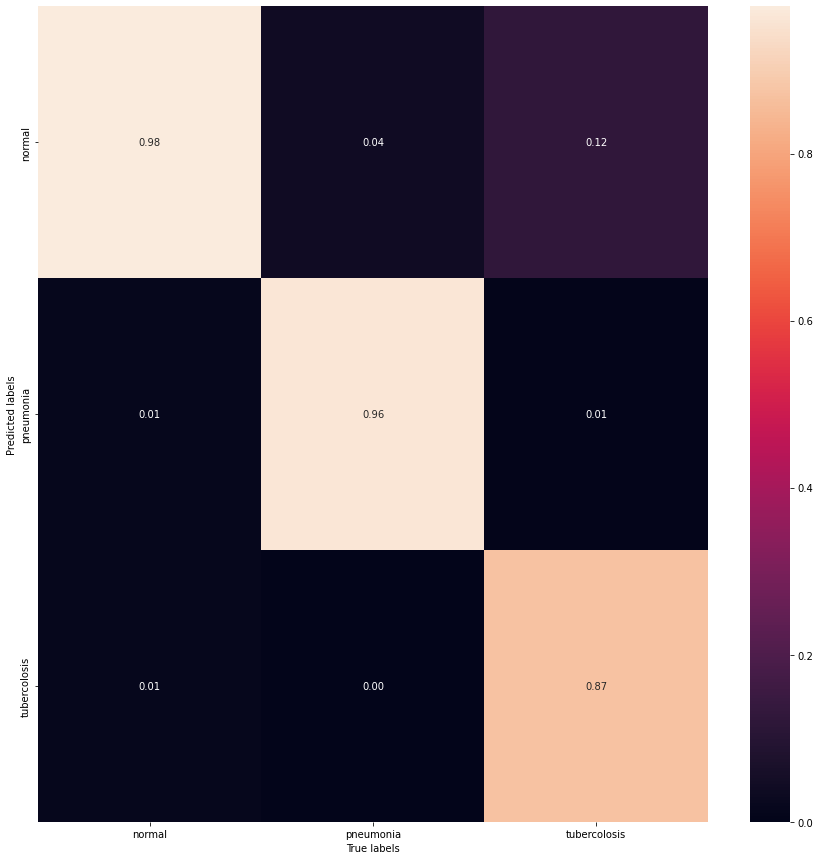

In [ ]:
#model = tfk.models.load_model("/content/gdrive/MyDrive/MODELS/FCDNP_EffNet_model_31_01")
# ret = evaluate_model_m(m, train_gen, train_target_cat)
# ret = evaluate_model_m(m, valid_gen, val_target_cat)
train1 = evaluate_model_m(model, test_gen, test_target_cat)

In [ ]:
import pickle 

with open('/content/gdrive/MyDrive/Assignment/MODELS/FCDNP_EffNet_Training1_pt2/perfomances1_FCDNP_EffNet_model_31_01.pkl', 'wb') as f: #TODO X
    pickle.dump(train1, f)

In [ ]:
#model = tfk.models.load_model("/content/gdrive/MyDrive/MODELS/FCDNP_EffNet_model_31_01")i
#model.summary()
model.save('/content/gdrive/MyDrive/Assignment/MODELS/FCDNP_EffNet_Training1_pt2/model')

##Training 2

In [ ]:
model = tfk.models.load_model('/content/gdrive/MyDrive/Assignment/MODELS/FCDNP_EffNet_Training1_pt2/model')

In [ ]:
epochs = 10
bs = data_hyperparameters['batch_size']
class_weights = dict(zip(np.unique(train_target), compute_class_weight(class_weight = "balanced", classes = np.unique(train_target), y = train_target)))
monmtr = 'val_accuracy'

In [ ]:
aug_callbacks = create_folders_and_callbacks(model_name='FCDNP_EffNet_Training2')

Model will be saved in: /content/gdrive/MyDrive/Assignment/MODELS/FCDNP_EffNet_Training2


In [ ]:
unfreeze_layers(model, untill=163, supernet_name='efficientnetb0', lr = 1e-3)
model.summary()

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
#@title If need to restore from last checkpoint do it here:

# Restore the model from the latest checkpoint

latest = tf.train.latest_checkpoint("/content/gdrive/MyDrive/Assignment/MODELS/FCDNP_EffNet_Training2/FCDNP_EffNet_Training2_Feb01_14-30-13/ckpts")
print(latest)

answer = input('Do you wish to load last checkpoint ? (Y/N) ')

if answer=='Y':
  # Use the restored model and evaluate performances
  print('Loading checkpoint')
  model.load_weights(latest)
  #print("These were last time performances: ") 
  #[val_loss] = model.evaluate(valid_gen)
else:
    print('I will not reload since last checkpoint')

/content/gdrive/MyDrive/Assignment/MODELS/FCDNP_EffNet_Training2/FCDNP_EffNet_Training2_Feb01_14-30-13/ckpts/cp.ckpt
Do you wish to load last checkpoint ? (Y/N) Y
Loading checkpoint


In [ ]:
history = model.fit(
    x = train_gen,
    epochs = epochs,
    #class_weight = class_weights,
    batch_size = bs, 
    validation_data = valid_gen,
    callbacks = aug_callbacks
).history

Epoch 1/10
87/87 [==============================] - 3000s 34s/step - loss: 0.0152 - accuracy: 0.9973 - precision: 0.9974 - recall: 0.9973 - val_loss: 0.2249 - val_accuracy: 0.9625 - val_precision: 0.9625 - val_recall: 0.9625 - lr: 1.0000e-05
Epoch 2/10
87/87 [==============================] - 1148s 13s/step - loss: 0.0179 - accuracy: 0.9960 - precision: 0.9962 - recall: 0.9959 - val_loss: 0.1973 - val_accuracy: 0.9673 - val_precision: 0.9681 - val_recall: 0.9673 - lr: 1.0000e-05
Epoch 3/10
87/87 [==============================] - 1136s 13s/step - loss: 0.0195 - accuracy: 0.9961 - precision: 0.9961 - recall: 0.9961 - val_loss: 0.2055 - val_accuracy: 0.9657 - val_precision: 0.9657 - val_recall: 0.9657 - lr: 1.0000e-05
Epoch 4/10
87/87 [==============================] - 1141s 13s/step - loss: 0.0154 - accuracy: 0.9975 - precision: 0.9977 - recall: 0.9974 - val_loss: 0.1976 - val_accuracy: 0.9673 - val_precision: 0.9673 - val_recall: 0.9665 - lr: 1.0000e-05
Epoch 5/10
87/87 [==============

In [ ]:
history = model.fit(
    x = train_gen,
    epochs = epochs,
    #class_weight = class_weights,
    batch_size = bs, 
    validation_data = valid_gen,
    callbacks = aug_callbacks
).history

Epoch 1/10
87/87 [==============================] - 8234s 95s/step - loss: 0.0113 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - val_loss: 0.1920 - val_accuracy: 0.9657 - val_precision: 0.9657 - val_recall: 0.9657 - lr: 2.5000e-06
Epoch 2/10
87/87 [==============================] - 162s 2s/step - loss: 0.0112 - accuracy: 0.9982 - precision: 0.9982 - recall: 0.9982 - val_loss: 0.1927 - val_accuracy: 0.9657 - val_precision: 0.9657 - val_recall: 0.9657 - lr: 2.5000e-06
Epoch 3/10
87/87 [==============================] - 161s 2s/step - loss: 0.0146 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - val_loss: 0.1874 - val_accuracy: 0.9673 - val_precision: 0.9673 - val_recall: 0.9673 - lr: 2.5000e-06
Epoch 4/10
87/87 [==============================] - 160s 2s/step - loss: 0.0122 - accuracy: 0.9977 - precision: 0.9977 - recall: 0.9975 - val_loss: 0.1897 - val_accuracy: 0.9681 - val_precision: 0.9681 - val_recall: 0.9681 - lr: 2.5000e-06
Epoch 5/10
87/87 [====================

In [ ]:
model.save("/content/gdrive/MyDrive/Assignment/MODELS/FCDNP_EffNet_Final") #save the model 

##Model evaluation 2

25/25 [==============================] - 285s 11s/step
Accuracy: 0.9566763659877142
F1 score: 0.9408341811574753


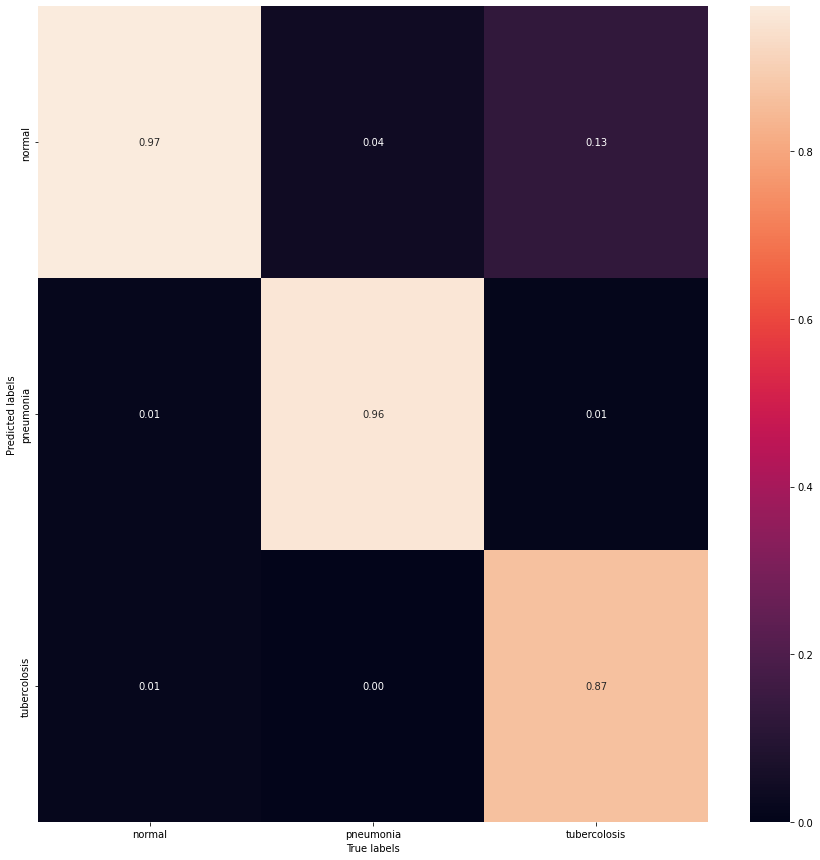

In [ ]:
ret2 = evaluate_model_m(model, test_gen, test_target_cat)

In [ ]:
import pickle
with open('/content/gdrive/MyDrive/Assignment/MODELS/FCDNP_EffNet_Final_predictions', 'wb') as f:
    pickle.dump(ret2, f)

In [ ]:
e = ret2['predictions']
e
np.save("/content/gdrive/MyDrive/Assignment/MODELS/FCDNP_EffNet_Final_predictions",e)